<a href="https://colab.research.google.com/github/kteppris/RealWaste/blob/main/DeepLearning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Training von Deep Learning Modellen mit PyTorch Lightning

- Setup der Pfade

In [1]:
import sys
import os
from pathlib import Path

# Funktion, die prüft, ob dieses Skript in Colab ausgeführt wird
def in_colab():
    # sys beinhaltet alle bereits geladenen Pakete
    return 'google.colab' in sys.modules  # google.colab wird automatisch in Colab vorgeladen, daher Indiz für Colab Environment

code_repo_path = Path("/content/drive/MyDrive/MADS/RealWaste") if in_colab() else Path.cwd()

if in_colab():
    # Google Drive einbinden zum persistieren von Code, Daten und Ergebnissen
    from google.colab import drive
    drive.mount('/content/drive')
    if not code_repo_path.exists():
        raise FileNotFoundError("Code und Datenordner konnte nicht gefunden werden. Bitte zuerst das Notebook '1_Hauptnotebook.ipynb' ausführen.")
    else:
        # wechsle Arbeitsverzeichnis zu code_repo_path
        %cd {code_repo_path}
        print(f"Wechsel Arbeitsverzeichnis zu {Path.cwd()}")
        %pip install -r requirements.txt
else:
    print("Stellen Sie sicher, dass das richtige Venv als Kernel ausgewählt ist,\nwelches wie in '1_Hauptnotebook.ipynb' beschrieben erstellt wurde.")

data_path = code_repo_path / "data"

Stellen Sie sicher, dass das richtige Venv als Kernel ausgewählt ist,
welches wie in '1_Hauptnotebook.ipynb' beschrieben erstellt wurde.


## Base Datamodule

- Basis des Datenmodules, sodass später nurnoch transformationen angepasst werden müssen

In [2]:
from pytorch_lightning import LightningDataModule
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader, random_split, Subset
from torchvision import transforms
import torch
import os
import numpy as np

class ConfigurableDataModule(LightningDataModule):
    def __init__(self, data_dir: str, batch_size: int, transform, workers=-1, seed=42):
        super().__init__()
        self.workers = os.cpu_count() if workers == -1 else workers
        self.data_dir = data_dir
        self.batch_size = batch_size
        self.transform = transform
        self.seed = seed

    def setup(self, stage=None):
        # Set the seed
        torch.manual_seed(self.seed)

        # Create the dataset instance
        full_dataset = ImageFolder(root=self.data_dir, transform=self.transform)

        # Implement stratified split
        train_indices, val_indices = self.stratified_split(full_dataset)

        # Creating subsets for training and validation
        self.train_dataset = Subset(full_dataset, train_indices)
        self.val_dataset = Subset(full_dataset, val_indices)

    def stratified_split(self, dataset):
        # Get targets from the dataset
        targets = np.array([sample[1] for sample in dataset.samples])
        
        # Calculate the number of samples per class to maintain distribution
        _, class_counts = np.unique(targets, return_counts=True)
        train_counts = (class_counts * 0.8).astype(int)  # 80% for training
        val_counts = class_counts - train_counts  # Remaining for validation

        train_indices = []
        val_indices = []

        for class_idx in range(len(class_counts)):
            indices = np.where(targets == class_idx)[0]
            np.random.shuffle(indices)  # Shuffle indices to ensure randomness
            
            train_indices.extend(indices[:train_counts[class_idx]])
            val_indices.extend(indices[train_counts[class_idx]:])

        # Shuffle the indices to mix classes
        np.random.shuffle(train_indices)
        np.random.shuffle(val_indices)

        return train_indices, val_indices

    def train_dataloader(self):
        return DataLoader(self.train_dataset, batch_size=self.batch_size, shuffle=True, num_workers=self.workers)

    def val_dataloader(self):
        return DataLoader(self.val_dataset, batch_size=self.batch_size, num_workers=self.workers)


## Base Lightning Module

- Basis für das Training und die individuellen Modelle

In [3]:
from PIL import Image, ImageDraw, ImageFont
import matplotlib.pyplot as plt
import pytorch_lightning as pl
import torch
import torchmetrics
from torchmetrics import MeanMetric
import torchvision
import torchvision.transforms.functional as F
import torchvision.utils as vutils
from torchvision.transforms.functional import to_pil_image, to_tensor
import random
import time
import shutil
from pathlib import Path

class BaseWasteClassifier(pl.LightningModule):
    CLASS_NAMES = ['Cardboard', 'Food Organics', 'Glass', 'Metal', 'Miscellaneous Trash', 'Paper', 'Plastic', 'Textile Trash', 'Vegetation']

    def __init__(self, num_classes: int, results_dir="results"):
        super().__init__()
        self.num_classes = num_classes
        # Klassennamen bekommen, für den result Ordner namen
        model_class_name = self.__class__.__name__
        
        # Ergebnisspfade definieren
        self.results_dir = Path(results_dir) / model_class_name
        self.models_dir = self.results_dir / "models"
        self.images_dir = self.results_dir / "images"
        self.logs_dir = self.results_dir / "logs"

        # Pfade erstellen
        self.results_dir.mkdir(parents=True, exist_ok=True)
        self.models_dir.mkdir(parents=True, exist_ok=True)
        self.images_dir.mkdir(parents=True, exist_ok=True)
        self.logs_dir.mkdir(parents=True, exist_ok=True)

        # Platzhalter wo später das tatsächlich Modell hinkommt
        # Wird bei konkreten Klassen definiert
        self.model = None

        # Metrik tracker initialisieren
        self.accuracy = torchmetrics.Accuracy(task='multiclass', num_classes=num_classes, average='macro')
        self.precision = torchmetrics.Precision(task='multiclass', num_classes=num_classes, average='weighted')
        self.recall = torchmetrics.Recall(task='multiclass', num_classes=num_classes, average='weighted')
        self.f1_score = torchmetrics.F1Score(task='multiclass', num_classes=num_classes, average='weighted')


    def forward(self, x):
        # Diese Method ist quasi "abstract" und muss von der jeweiligen konkreten Klasse definiert werden
        raise NotImplementedError("This method should be overridden by subclasses.")

    def training_step(self, batch, batch_idx):
        x, y = batch
        outputs = self(x)
        logits = outputs if isinstance(outputs, torch.Tensor) else outputs[0]  
        loss = torch.nn.functional.cross_entropy(logits, y)
        acc = self.accuracy(torch.argmax(logits, dim=1), y)
        precision = self.precision(torch.argmax(logits, dim=1), y)
        recall = self.recall(torch.argmax(logits, dim=1), y)
        f1 = self.f1_score(torch.argmax(logits, dim=1), y)  

        self.log('train_loss', loss, on_step=True, on_epoch=True, prog_bar=True, logger=True)
        self.log('train_acc', acc, on_step=True, on_epoch=True, prog_bar=True, logger=True)
        # Log precision, recall, and F1 Score
        self.log('train_precision', precision, on_step=True, on_epoch=True, prog_bar=True, logger=True)
        self.log('train_recall', recall, on_step=True, on_epoch=True, prog_bar=True, logger=True)
        self.log('train_f1', f1, on_step=True, on_epoch=True, prog_bar=True, logger=True)
        return loss

    def on_validation_start(self):
        self.clear_images_directory()

    def validation_step(self, batch, batch_idx):
        # Start Zeit zwischenspeichern
        start_time = time.perf_counter()  
        
        # batch in trainingsbilder und label teilen
        x, y = batch
        # Vorhersage Logits bekomm
        logits = self(x)
        # Berechnung der Loss und der Metriken
        loss = torch.nn.functional.cross_entropy(logits, y)
        acc = self.accuracy(torch.argmax(logits, dim=1), y)
        precision = self.precision(torch.argmax(logits, dim=1), y)
        recall = self.recall(torch.argmax(logits, dim=1), y)
        f1 = self.f1_score(torch.argmax(logits, dim=1), y)

        inference_time = time.perf_counter() - start_time  # Stop timing for inference speed
        self.log('val_inference_time', inference_time, prog_bar=True, logger=True)

        self.log('val_loss', loss, prog_bar=True)
        self.log('val_acc', acc, prog_bar=True)
        # Log precision, recall, and F1 Score
        self.log('val_precision', precision, prog_bar=True)
        self.log('val_recall', recall, prog_bar=True)
        self.log('val_f1', f1, prog_bar=True)

        predictions = torch.argmax(logits, dim=1)  # Convert logits to predicted class indices

        if random.random() < 0.1:  # Log images randomly
            self.log_images_with_labels(x, y, predictions, batch_idx)
        return loss

    def log_images_with_labels(self, images, labels, predictions, batch_idx):
        """Save a batch of images with their actual and predicted labels, organized by class name and model class."""
        annotated_images = []
        for i, (image, label, prediction) in enumerate(zip(images, labels, predictions)):
            # Unnormalize the image for visualization
            image = self.unnormalize(image)  # Make sure to call with self if it's an instance method
            # Determine class name for the actual label
            actual_class_name = self.CLASS_NAMES[label.item()]

            # Ensure the class-specific directory exists within the model class directory
            image_dir = self.images_dir / actual_class_name
            image_dir.mkdir(parents=True, exist_ok=True)

            # Convert to PIL Image for easy manipulation
            pil_img = F.to_pil_image(image)

            # Annotate image with actual and predicted labels
            draw = ImageDraw.Draw(pil_img)
            annotation_text = f'Actual: {actual_class_name}, Predicted: {self.CLASS_NAMES[prediction.item()]}'
            draw.text((10, 10), annotation_text, fill="white")

            # Define the file path for saving the image within the specific class directory
            file_path = image_dir / f"epoch_{self.current_epoch}_batch_{batch_idx}_image_{i}.png"

            # Save the annotated image
            pil_img.save(file_path)

            # Convert back to tensor and add to list
            annotated_img = to_tensor(pil_img)
            annotated_images.append(annotated_img.unsqueeze(0))  # Add batch dimension

        # Stack all annotated images into a single tensor for logging
        annotated_images_tensor = torch.cat(annotated_images, dim=0)
        img_grid = torchvision.utils.make_grid(annotated_images_tensor, nrow=4)

        # Log the grid of annotated images
        self.logger.experiment.add_image(f'Validation Images, Batch {batch_idx}', img_grid, self.current_epoch)

    def clear_images_directory(self):
        if self.images_dir.exists() and self.images_dir.is_dir():
            for class_dir in self.images_dir.iterdir():
                if class_dir.is_dir():  # Ensure it's a directory
                    shutil.rmtree(class_dir)  # Delete the directory and all its contents

    def unnormalize(self, image, mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]):
        """Revert normalization of an image tensor."""
        image = image.clone()  # Clone the tensor to avoid in-place operations
        for t, m, s in zip(image, mean, std):
            t.mul_(s).add_(m)  # Multiply by std and add mean
        return image

    def configure_optimizers(self):
        # Subclasses can override this if needed
        optimizer = torch.optim.SGD(self.model.parameters(), lr=0.001, momentum=0.9)
        return optimizer


## PyTorch Lightning Callbacks

- Funktion die checkpoint und early stop callback vorbereit
- Reduziert das laden dieser Callbacks for jedem Training zu einer Zeile Code

In [4]:
from pytorch_lightning.callbacks import ModelCheckpoint
from pytorch_lightning.callbacks import EarlyStopping

def get_callbacks(model_checkpoint_path: str, early_stop_patience=2):
    callbacks = []

    # Configure the ModelCheckpoint callback
    checkpoint_callback = ModelCheckpoint(
        dirpath=model_checkpoint_path,
        filename='{epoch}-{val_loss:.2f}',
        save_top_k=2,  # Save only the best checkpoint
        verbose=True,
        monitor='val_loss',  # Monitor validation loss (change to val_acc or any other metric as needed)
        mode='min',  # 'min' for loss (use 'max' for accuracy)
    )
    callbacks.append(checkpoint_callback)

    # Stoppt des Training wenn sich val Metrik nicht verbessert
    early_stopping_callback = EarlyStopping(
        monitor="val_acc",  # Die Metrik beobachtet wird
        mode="max",  # Maximiert die Genauigkeit
        patience=early_stop_patience,  # "Wartet" 2 Epoche ohne Verbesserung
    )
    callbacks.append(early_stopping_callback)
    return callbacks



## Train Modell Funktion

- Initialisiert Logger
- Startet Training

In [5]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path  # Ensure you import Path for handling file paths

sns.set()

def make_summary_plots(logs_dir):
    metrics_df = pd.read_csv(Path(logs_dir) / 'metrics.csv')

    # Group by 'epoch' and aggregate the metrics.
    agg_funcs = {col: 'last' for col in metrics_df.columns if 'epoch' in col or 'val_' in col}
    metrics_df = metrics_df.groupby('epoch', as_index=False).agg(agg_funcs)

    # Plotting
    fig, axs = plt.subplots(1, 3, figsize=(15, 5))  # Adjust to a single row with three columns
    fig.suptitle('Training and Validation Metrics Over Epochs')

    # Loss Funktionen 
    axs[0].plot(metrics_df['epoch'], metrics_df['train_loss_epoch'], label='Train Loss')
    axs[0].plot(metrics_df['epoch'], metrics_df['val_loss'], label='Validation Loss')
    axs[0].set_title('Loss')
    axs[0].set_xlabel('Epoch')
    axs[0].set_ylabel('Loss')
    axs[0].set_ylim(0, 2.0)  # Set y-axis range for loss
    axs[0].legend()

    # Accuracy Plot
    axs[1].plot(metrics_df['epoch'], metrics_df['train_acc_epoch'], label='Train Accuracy')
    axs[1].plot(metrics_df['epoch'], metrics_df['val_acc'], label='Validation Accuracy')
    axs[1].set_title('Accuracy')
    axs[1].set_xlabel('Epoch')
    axs[1].set_ylabel('Accuracy')
    axs[1].set_ylim(0, 1)  # Set y-axis range for percentage metrics
    axs[1].legend()

    # Precision, Recall, and F1 Score Plot
    axs[2].plot(metrics_df['epoch'], metrics_df['train_precision_epoch'], label='Train Precision')
    axs[2].plot(metrics_df['epoch'], metrics_df['val_precision'], label='Validation Precision')
    axs[2].plot(metrics_df['epoch'], metrics_df['train_recall_epoch'], label='Train Recall')
    axs[2].plot(metrics_df['epoch'], metrics_df['val_recall'], label='Validation Recall')
    axs[2].plot(metrics_df['epoch'], metrics_df['train_f1_epoch'], label='Train F1 Score')
    axs[2].plot(metrics_df['epoch'], metrics_df['val_f1'], label='Validation F1 Score')
    axs[2].set_title('Precision, Recall & F1 Score')
    axs[2].set_xlabel('Epoch')
    axs[2].set_ylabel('Score')
    axs[2].set_ylim(0, 1)  # Set y-axis range for percentage metrics
    axs[2].legend()

    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.show()


In [6]:
import os
from pytorch_lightning import Trainer
from pytorch_lightning.loggers import TensorBoardLogger
from pytorch_lightning.loggers import CSVLogger


def train_model(model, data_module, tb_log_dir="results/tb_logs", max_epochs=50, logger_name="model_logs", callbacks=[]):
    # Define the loggers
    tb_logger = TensorBoardLogger(tb_log_dir, name=logger_name)
    csv_logger = CSVLogger(model.results_dir, name="logs")
    
    trainer = Trainer(max_epochs=max_epochs, logger=[tb_logger, csv_logger], callbacks=callbacks)
    trainer.fit(model, datamodule=data_module)

    # After training, plot the summary
    make_summary_plots(csv_logger.log_dir)


In [7]:
%reload_ext tensorboard
%tensorboard --logdir={code_repo_path / "results/tb_logs"}

Reusing TensorBoard on port 6006 (pid 217659), started 0:41:18 ago. (Use '!kill 217659' to kill it.)

## SimpleCNN

In [8]:
import torch.nn as nn

class SimpleCNN(BaseWasteClassifier):
    def __init__(self, num_classes=9, lr=1e-3):
        self.lr = 1e-3
        super().__init__(num_classes)
        self.model = nn.Sequential(
            nn.Conv2d(3, 16, 3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Conv2d(16, 32, 3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Conv2d(32, 64, 3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Flatten(),
            nn.Linear(64 * 28 * 28, 512),  # Bestätigt, dass dies für eine Eingabegröße von 224x224 korrekt ist
            nn.ReLU(),
            nn.Dropout(0.5), # Overfitting vermeiden
            nn.Linear(512, num_classes) # lineare Schicht auf die Klassen
        )


    def forward(self, x):
        return self.model(x)

    def configure_optimizers(self):
        optimizer = torch.optim.Adam(self.parameters(), lr=self.lr)
        return optimizer

### Train SimpleCNN

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
You are using a CUDA device ('NVIDIA RTX A6000') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
Missing logger folder: results/tb_logs/simple_CNN
2024-02-25 20:08:48.677569: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-02-25 20:08:48.677614: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-02-25 20:08:48.

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 0, global step 119: 'val_loss' reached 1.24018 (best 1.24018), saving model to '/home/jovyan/work/Sonstiges/Module/Machine_Learning/RealWaste/results/SimpleCNN/models/epoch=0-val_loss=1.24.ckpt' as top 2


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 1, global step 238: 'val_loss' reached 1.06254 (best 1.06254), saving model to '/home/jovyan/work/Sonstiges/Module/Machine_Learning/RealWaste/results/SimpleCNN/models/epoch=1-val_loss=1.06.ckpt' as top 2


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 2, global step 357: 'val_loss' reached 0.93359 (best 0.93359), saving model to '/home/jovyan/work/Sonstiges/Module/Machine_Learning/RealWaste/results/SimpleCNN/models/epoch=2-val_loss=0.93.ckpt' as top 2


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 3, global step 476: 'val_loss' reached 0.93658 (best 0.93359), saving model to '/home/jovyan/work/Sonstiges/Module/Machine_Learning/RealWaste/results/SimpleCNN/models/epoch=3-val_loss=0.94.ckpt' as top 2


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 4, global step 595: 'val_loss' reached 0.93198 (best 0.93198), saving model to '/home/jovyan/work/Sonstiges/Module/Machine_Learning/RealWaste/results/SimpleCNN/models/epoch=4-val_loss=0.93.ckpt' as top 2


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 5, global step 714: 'val_loss' was not in top 2


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 6, global step 833: 'val_loss' was not in top 2


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 7, global step 952: 'val_loss' was not in top 2


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 8, global step 1071: 'val_loss' was not in top 2


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 9, global step 1190: 'val_loss' was not in top 2
`Trainer.fit` stopped: `max_epochs=10` reached.


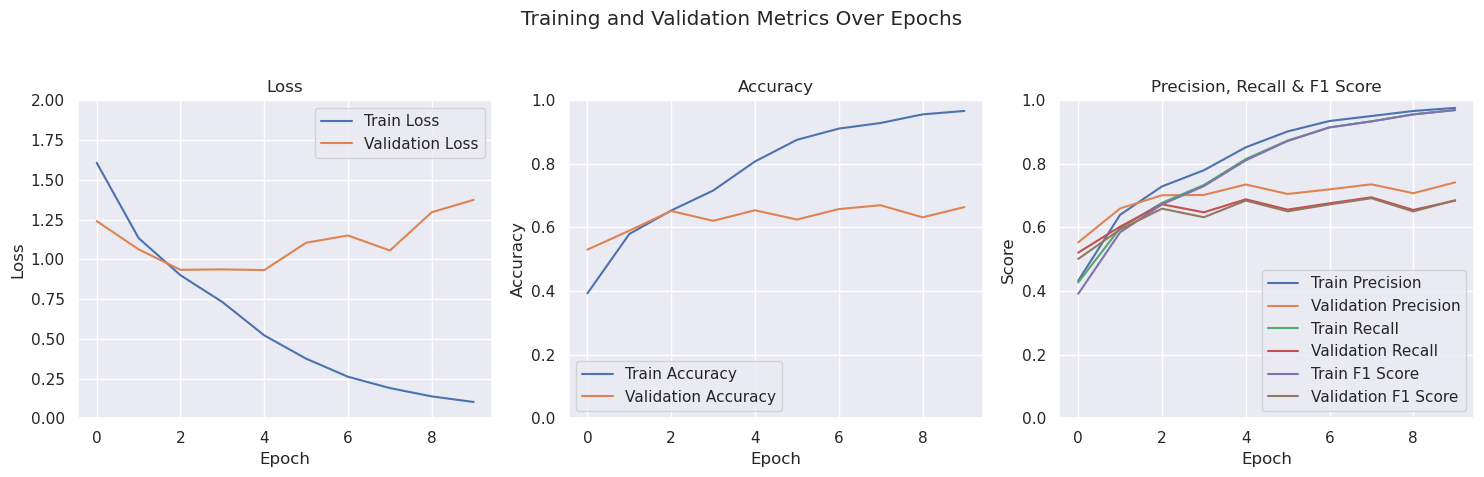

In [9]:
from torchvision import transforms
# Definiere die Transformationspipeline
transform = transforms.Compose([
    transforms.Resize((224, 224)),  # Skaliere alle Bilder auf 224x224
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])


data_module = ConfigurableDataModule(data_dir=data_path, batch_size=32, transform=transform)
model = SimpleCNN(num_classes=9, lr=1e-3)
callbacks = get_callbacks(
    model_checkpoint_path=model.models_dir,
    early_stop_patience=2
)
train_model(model, data_module, max_epochs=10, logger_name="simple_CNN", callbacks=callbacks)

# InceptionWasteClassifier

In [10]:
from torchvision.models import inception_v3

class Inception_v3_WasteClassifier(BaseWasteClassifier):
    def __init__(self, num_classes=9):
        super().__init__(num_classes)
        self.model = inception_v3(aux_logits=True, weights="Inception_V3_Weights.DEFAULT")
        self.model.fc = torch.nn.Linear(self.model.fc.in_features, num_classes)

    def forward(self, x):
        if self.training:
            outputs = self.model(x)
            return outputs.logits, outputs.aux_logits
        else:
            return self.model(x)


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
Missing logger folder: results/tb_logs/Inception_v3
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name      | Type                | Params
--------------------------------------------------
0 | accuracy  | MulticlassAccuracy  | 0     
1 | precision | MulticlassPrecision | 0     
2 | recall    | MulticlassRecall    | 0     
3 | f1_score  | MulticlassF1Score   | 0     
4 | model     | Inception3          | 25.1 M
--------------------------------------------------
25.1 M    Trainable params
0         Non-trainable params
25.1 M    Total params
100.523   Total estimated model params size (MB)


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 0, global step 119: 'val_loss' reached 0.88046 (best 0.88046), saving model to '/home/jovyan/work/Sonstiges/Module/Machine_Learning/RealWaste/results/Inception_v3_WasteClassifier/models/epoch=0-val_loss=0.88.ckpt' as top 2


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 1, global step 238: 'val_loss' reached 0.53224 (best 0.53224), saving model to '/home/jovyan/work/Sonstiges/Module/Machine_Learning/RealWaste/results/Inception_v3_WasteClassifier/models/epoch=1-val_loss=0.53.ckpt' as top 2


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 2, global step 357: 'val_loss' reached 0.43049 (best 0.43049), saving model to '/home/jovyan/work/Sonstiges/Module/Machine_Learning/RealWaste/results/Inception_v3_WasteClassifier/models/epoch=2-val_loss=0.43.ckpt' as top 2


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 3, global step 476: 'val_loss' reached 0.37683 (best 0.37683), saving model to '/home/jovyan/work/Sonstiges/Module/Machine_Learning/RealWaste/results/Inception_v3_WasteClassifier/models/epoch=3-val_loss=0.38.ckpt' as top 2


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 4, global step 595: 'val_loss' reached 0.35018 (best 0.35018), saving model to '/home/jovyan/work/Sonstiges/Module/Machine_Learning/RealWaste/results/Inception_v3_WasteClassifier/models/epoch=4-val_loss=0.35.ckpt' as top 2


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 5, global step 714: 'val_loss' reached 0.35027 (best 0.35018), saving model to '/home/jovyan/work/Sonstiges/Module/Machine_Learning/RealWaste/results/Inception_v3_WasteClassifier/models/epoch=5-val_loss=0.35.ckpt' as top 2


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 6, global step 833: 'val_loss' was not in top 2


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 7, global step 952: 'val_loss' was not in top 2


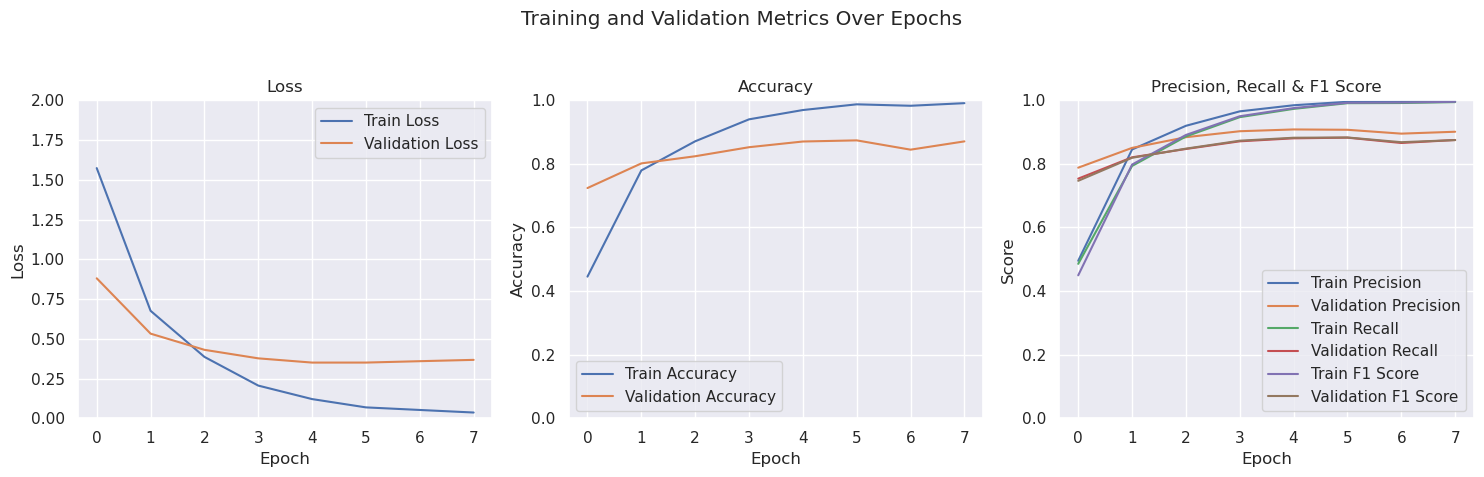

In [11]:
from torchvision import transforms
from torchvision.transforms.functional import InterpolationMode

# Define the transformations as per Inception V3's requirements
transform = transforms.Compose([
    transforms.Resize(342, interpolation=InterpolationMode.BILINEAR),
    transforms.CenterCrop(299),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])
batch_size = 32
data_module = ConfigurableDataModule(data_path, batch_size, transform, workers=4) # setze auf 4 worker wegen ERROR: Nicht genug shared memory, durch multiprocessing

model = Inception_v3_WasteClassifier()
callbacks = get_callbacks(
    model_checkpoint_path=model.models_dir,
    early_stop_patience=2
)
train_model(model, data_module, max_epochs=50, logger_name="Inception_v3", callbacks=callbacks)

# DenseNetWasteClassifier

In [12]:
from torchvision.models import densenet201

class DenseNet201WasteClassifier(BaseWasteClassifier):
    def __init__(self, num_classes=9):
        super().__init__(num_classes)
        self.model = densenet201(weights="DenseNet201_Weights.DEFAULT")
        self.model.classifier = torch.nn.Linear(self.model.classifier.in_features, num_classes)

    def forward(self, x):
        return self.model(x)

In [13]:
from torchvision.transforms.functional import InterpolationMode
# Define the transformations as per Inception V3's requirements
transform = transforms.Compose([
    transforms.Resize(256, interpolation=InterpolationMode.BILINEAR),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
Missing logger folder: results/tb_logs/densenet201
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name      | Type                | Params
--------------------------------------------------
0 | accuracy  | MulticlassAccuracy  | 0     
1 | precision | MulticlassPrecision | 0     
2 | recall    | MulticlassRecall    | 0     
3 | f1_score  | MulticlassF1Score   | 0     
4 | model     | DenseNet            | 18.1 M
--------------------------------------------------
18.1 M    Trainable params
0         Non-trainable params
18.1 M    Total params
72.441    Total estimated model params size (MB)


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 0, global step 119: 'val_loss' reached 0.56602 (best 0.56602), saving model to '/home/jovyan/work/Sonstiges/Module/Machine_Learning/RealWaste/results/DenseNet201WasteClassifier/models/epoch=0-val_loss=0.57.ckpt' as top 2


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 1, global step 238: 'val_loss' reached 0.36998 (best 0.36998), saving model to '/home/jovyan/work/Sonstiges/Module/Machine_Learning/RealWaste/results/DenseNet201WasteClassifier/models/epoch=1-val_loss=0.37.ckpt' as top 2


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 2, global step 357: 'val_loss' reached 0.29025 (best 0.29025), saving model to '/home/jovyan/work/Sonstiges/Module/Machine_Learning/RealWaste/results/DenseNet201WasteClassifier/models/epoch=2-val_loss=0.29.ckpt' as top 2


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 3, global step 476: 'val_loss' reached 0.26078 (best 0.26078), saving model to '/home/jovyan/work/Sonstiges/Module/Machine_Learning/RealWaste/results/DenseNet201WasteClassifier/models/epoch=3-val_loss=0.26.ckpt' as top 2


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 4, global step 595: 'val_loss' reached 0.24196 (best 0.24196), saving model to '/home/jovyan/work/Sonstiges/Module/Machine_Learning/RealWaste/results/DenseNet201WasteClassifier/models/epoch=4-val_loss=0.24.ckpt' as top 2


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 5, global step 714: 'val_loss' reached 0.22580 (best 0.22580), saving model to '/home/jovyan/work/Sonstiges/Module/Machine_Learning/RealWaste/results/DenseNet201WasteClassifier/models/epoch=5-val_loss=0.23.ckpt' as top 2


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 6, global step 833: 'val_loss' reached 0.23010 (best 0.22580), saving model to '/home/jovyan/work/Sonstiges/Module/Machine_Learning/RealWaste/results/DenseNet201WasteClassifier/models/epoch=6-val_loss=0.23.ckpt' as top 2


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 7, global step 952: 'val_loss' reached 0.22630 (best 0.22580), saving model to '/home/jovyan/work/Sonstiges/Module/Machine_Learning/RealWaste/results/DenseNet201WasteClassifier/models/epoch=7-val_loss=0.23.ckpt' as top 2


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 8, global step 1071: 'val_loss' was not in top 2


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 9, global step 1190: 'val_loss' reached 0.21961 (best 0.21961), saving model to '/home/jovyan/work/Sonstiges/Module/Machine_Learning/RealWaste/results/DenseNet201WasteClassifier/models/epoch=9-val_loss=0.22.ckpt' as top 2


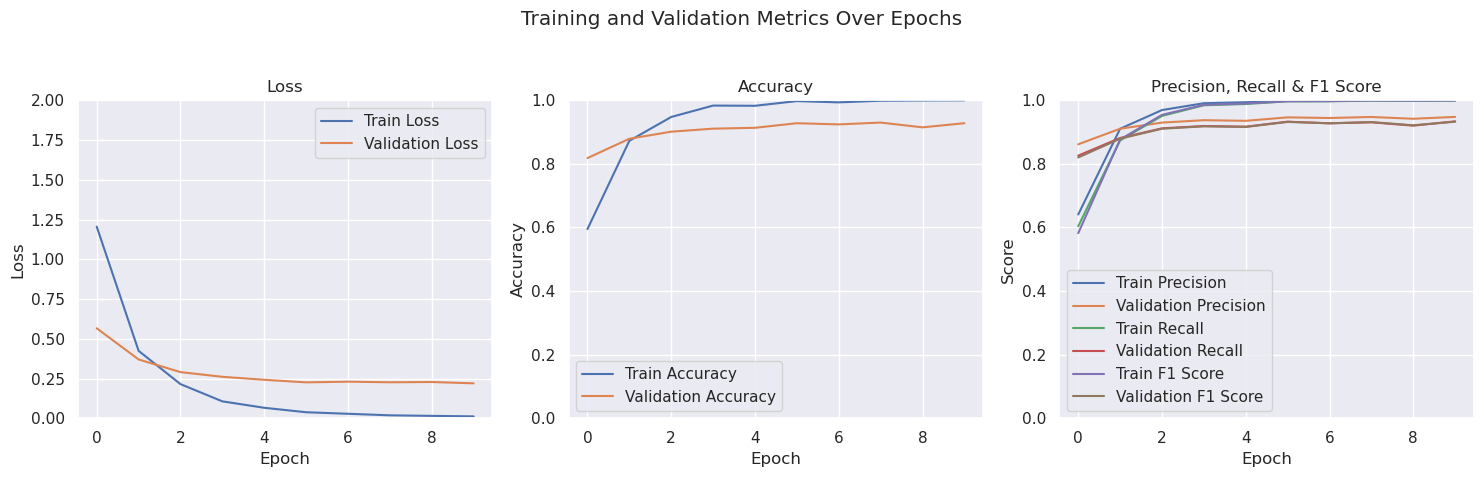

In [14]:
data_module = ConfigurableDataModule(data_dir=data_path, batch_size=32, transform=transform)

model = DenseNet201WasteClassifier(num_classes=9)

callbacks = get_callbacks(
    model_checkpoint_path=model.models_dir,
    early_stop_patience=2
)

train_model(model, data_module, max_epochs=50, logger_name="densenet201", callbacks=callbacks)



# Resnet50

In [15]:
from torchvision.models import resnet50

class ResNet50WasteClassifier(BaseWasteClassifier):
    def __init__(self, num_classes=9):
        super().__init__(num_classes)
        self.model = resnet50(weights="ResNet50_Weights.DEFAULT")
        self.model.fc = torch.nn.Linear(self.model.fc.in_features, num_classes)

    def forward(self, x):
        return self.model(x)

In [16]:
from torchvision.transforms.functional import InterpolationMode

transform = transforms.Compose([
    transforms.Resize(256, interpolation=InterpolationMode.BILINEAR),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
Missing logger folder: results/tb_logs/resnet50
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name      | Type                | Params
--------------------------------------------------
0 | accuracy  | MulticlassAccuracy  | 0     
1 | precision | MulticlassPrecision | 0     
2 | recall    | MulticlassRecall    | 0     
3 | f1_score  | MulticlassF1Score   | 0     
4 | model     | ResNet              | 23.5 M
--------------------------------------------------
23.5 M    Trainable params
0         Non-trainable params
23.5 M    Total params
94.106    Total estimated model params size (MB)


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 0, global step 119: 'val_loss' reached 1.23184 (best 1.23184), saving model to '/home/jovyan/work/Sonstiges/Module/Machine_Learning/RealWaste/results/ResNet50WasteClassifier/models/epoch=0-val_loss=1.23.ckpt' as top 2


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 1, global step 238: 'val_loss' reached 0.66244 (best 0.66244), saving model to '/home/jovyan/work/Sonstiges/Module/Machine_Learning/RealWaste/results/ResNet50WasteClassifier/models/epoch=1-val_loss=0.66.ckpt' as top 2


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 2, global step 357: 'val_loss' reached 0.48616 (best 0.48616), saving model to '/home/jovyan/work/Sonstiges/Module/Machine_Learning/RealWaste/results/ResNet50WasteClassifier/models/epoch=2-val_loss=0.49.ckpt' as top 2


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 3, global step 476: 'val_loss' reached 0.40051 (best 0.40051), saving model to '/home/jovyan/work/Sonstiges/Module/Machine_Learning/RealWaste/results/ResNet50WasteClassifier/models/epoch=3-val_loss=0.40.ckpt' as top 2


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 4, global step 595: 'val_loss' reached 0.35182 (best 0.35182), saving model to '/home/jovyan/work/Sonstiges/Module/Machine_Learning/RealWaste/results/ResNet50WasteClassifier/models/epoch=4-val_loss=0.35.ckpt' as top 2


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 5, global step 714: 'val_loss' reached 0.32204 (best 0.32204), saving model to '/home/jovyan/work/Sonstiges/Module/Machine_Learning/RealWaste/results/ResNet50WasteClassifier/models/epoch=5-val_loss=0.32.ckpt' as top 2


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 6, global step 833: 'val_loss' reached 0.29817 (best 0.29817), saving model to '/home/jovyan/work/Sonstiges/Module/Machine_Learning/RealWaste/results/ResNet50WasteClassifier/models/epoch=6-val_loss=0.30.ckpt' as top 2


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 7, global step 952: 'val_loss' reached 0.28388 (best 0.28388), saving model to '/home/jovyan/work/Sonstiges/Module/Machine_Learning/RealWaste/results/ResNet50WasteClassifier/models/epoch=7-val_loss=0.28.ckpt' as top 2


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 8, global step 1071: 'val_loss' reached 0.29228 (best 0.28388), saving model to '/home/jovyan/work/Sonstiges/Module/Machine_Learning/RealWaste/results/ResNet50WasteClassifier/models/epoch=8-val_loss=0.29.ckpt' as top 2


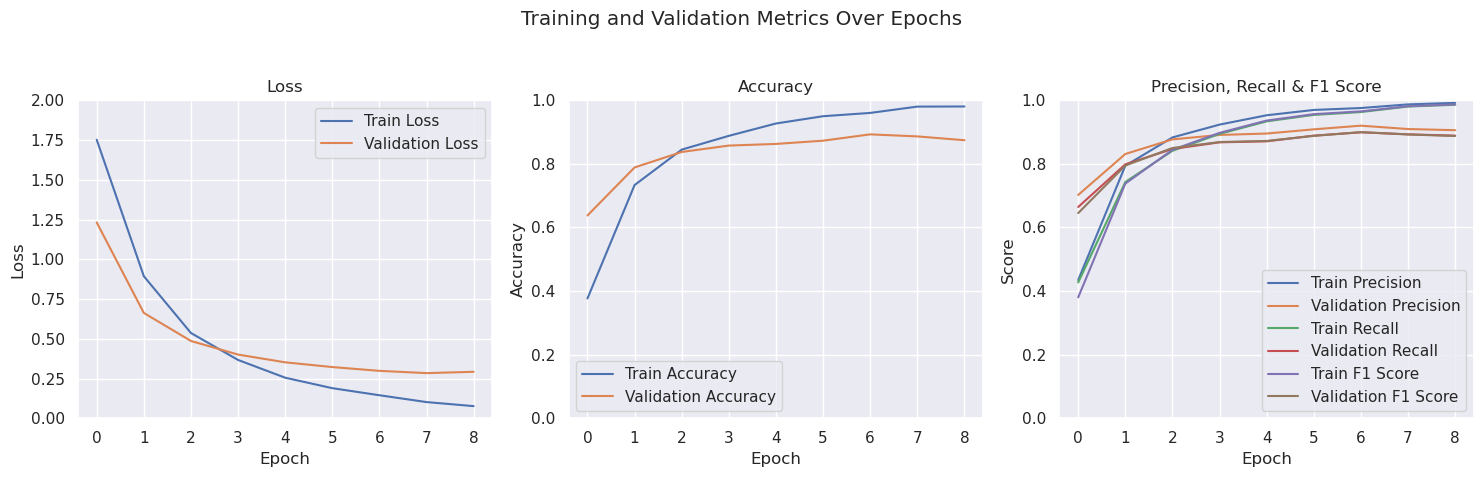

In [17]:
data_module = ConfigurableDataModule(data_dir=data_path, batch_size=32, transform=transform)

model = ResNet50WasteClassifier(num_classes=9)
callbacks = get_callbacks(
    model_checkpoint_path=model.models_dir,
    early_stop_patience=2
)
train_model(model, data_module, max_epochs=50, logger_name="resnet50", callbacks=callbacks)


# VGG16

In [18]:
from torchvision.models import vgg16

class VGG16WasteClassifier(BaseWasteClassifier):
    def __init__(self, num_classes=9):
        super().__init__(num_classes)
        self.model = vgg16(weights="VGG16_Weights.DEFAULT")
        in_features = self.model.classifier[6].in_features
        self.model.classifier[6] = torch.nn.Linear(in_features, num_classes)

    def forward(self, x):
        return self.model(x)

In [19]:
from torchvision.transforms.functional import InterpolationMode

transform = transforms.Compose([
    transforms.Resize(256, interpolation=InterpolationMode.BILINEAR),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
Missing logger folder: results/tb_logs/vgg16
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name      | Type                | Params
--------------------------------------------------
0 | accuracy  | MulticlassAccuracy  | 0     
1 | precision | MulticlassPrecision | 0     
2 | recall    | MulticlassRecall    | 0     
3 | f1_score  | MulticlassF1Score   | 0     
4 | model     | VGG                 | 134 M 
--------------------------------------------------
134 M     Trainable params
0         Non-trainable params
134 M     Total params
537.190   Total estimated model params size (MB)


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 0, global step 119: 'val_loss' reached 0.64266 (best 0.64266), saving model to '/home/jovyan/work/Sonstiges/Module/Machine_Learning/RealWaste/results/VGG16WasteClassifier/models/epoch=0-val_loss=0.64.ckpt' as top 2


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 1, global step 238: 'val_loss' reached 0.42639 (best 0.42639), saving model to '/home/jovyan/work/Sonstiges/Module/Machine_Learning/RealWaste/results/VGG16WasteClassifier/models/epoch=1-val_loss=0.43.ckpt' as top 2


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 2, global step 357: 'val_loss' reached 0.35679 (best 0.35679), saving model to '/home/jovyan/work/Sonstiges/Module/Machine_Learning/RealWaste/results/VGG16WasteClassifier/models/epoch=2-val_loss=0.36.ckpt' as top 2


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 3, global step 476: 'val_loss' was not in top 2


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 4, global step 595: 'val_loss' reached 0.39097 (best 0.35679), saving model to '/home/jovyan/work/Sonstiges/Module/Machine_Learning/RealWaste/results/VGG16WasteClassifier/models/epoch=4-val_loss=0.39.ckpt' as top 2


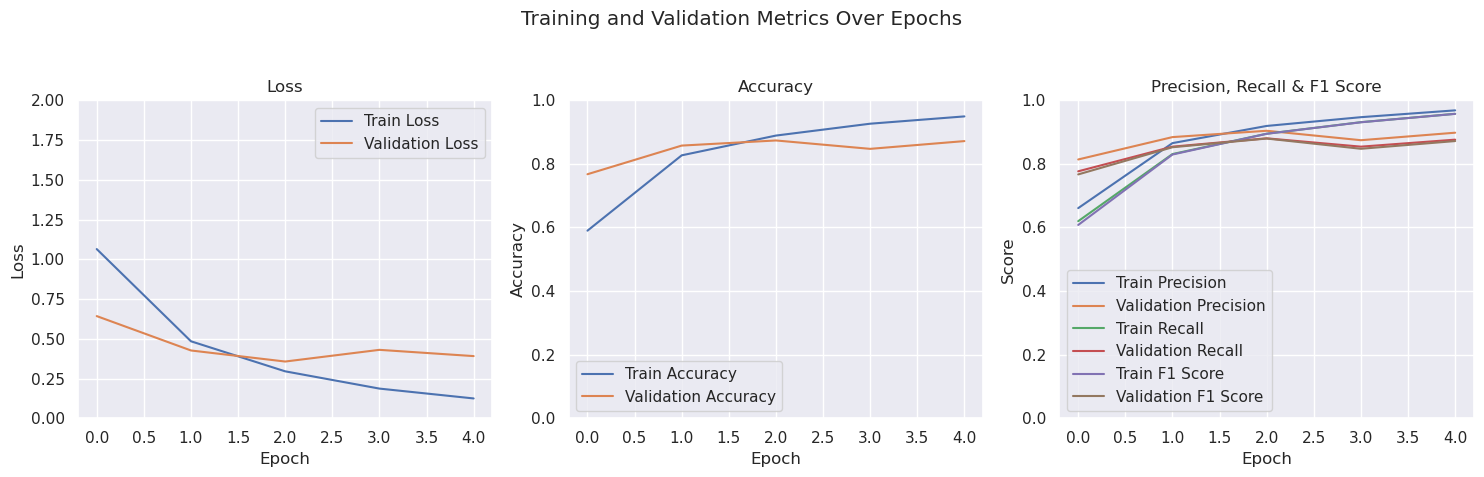

In [20]:
data_module = ConfigurableDataModule(data_dir=data_path, batch_size=32, transform=transform)

model = VGG16WasteClassifier(num_classes=9)
callbacks = get_callbacks(
    model_checkpoint_path=model.models_dir,
    early_stop_patience=2
)
train_model(model, data_module, max_epochs=50, logger_name="vgg16", callbacks=callbacks)


# Vision Transformer

In [21]:
from torchvision.models import vit_l_16

class VitWasteClassifier(BaseWasteClassifier):
    def __init__(self, num_classes=9):
        super().__init__(num_classes)
        self.model = vit_l_16(weights="ViT_L_16_Weights.DEFAULT")
        in_features = self.model.heads.head.in_features
        self.model.heads.head = torch.nn.Linear(in_features=in_features, out_features=num_classes)

    def forward(self, x):
        return self.model(x)

In [22]:
from torchvision.transforms.functional import InterpolationMode

transform = transforms.Compose([
    transforms.Resize(242, interpolation=InterpolationMode.BILINEAR),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
Missing logger folder: results/tb_logs/ViT-l-16
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name      | Type                | Params
--------------------------------------------------
0 | accuracy  | MulticlassAccuracy  | 0     
1 | precision | MulticlassPrecision | 0     
2 | recall    | MulticlassRecall    | 0     
3 | f1_score  | MulticlassF1Score   | 0     
4 | model     | VisionTransformer   | 303 M 
--------------------------------------------------
303 M     Trainable params
0         Non-trainable params
303 M     Total params
1,213.243 Total estimated model params size (MB)


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 0, global step 119: 'val_loss' reached 0.43806 (best 0.43806), saving model to '/home/jovyan/work/Sonstiges/Module/Machine_Learning/RealWaste/results/VitWasteClassifier/models/epoch=0-val_loss=0.44.ckpt' as top 2


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 1, global step 238: 'val_loss' reached 0.32643 (best 0.32643), saving model to '/home/jovyan/work/Sonstiges/Module/Machine_Learning/RealWaste/results/VitWasteClassifier/models/epoch=1-val_loss=0.33.ckpt' as top 2


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 2, global step 357: 'val_loss' reached 0.24784 (best 0.24784), saving model to '/home/jovyan/work/Sonstiges/Module/Machine_Learning/RealWaste/results/VitWasteClassifier/models/epoch=2-val_loss=0.25.ckpt' as top 2


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 3, global step 476: 'val_loss' reached 0.22726 (best 0.22726), saving model to '/home/jovyan/work/Sonstiges/Module/Machine_Learning/RealWaste/results/VitWasteClassifier/models/epoch=3-val_loss=0.23.ckpt' as top 2


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 4, global step 595: 'val_loss' reached 0.23015 (best 0.22726), saving model to '/home/jovyan/work/Sonstiges/Module/Machine_Learning/RealWaste/results/VitWasteClassifier/models/epoch=4-val_loss=0.23.ckpt' as top 2


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 5, global step 714: 'val_loss' was not in top 2


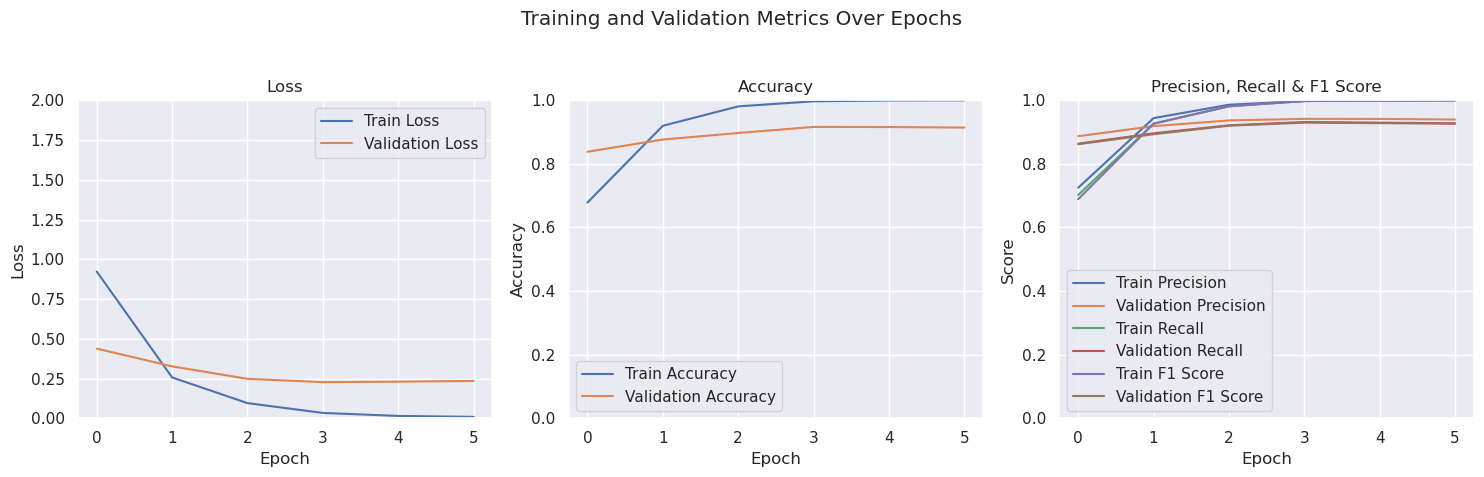

In [23]:
data_module = ConfigurableDataModule(data_dir=data_path, batch_size=32, transform=transform)

model = VitWasteClassifier(num_classes=9)
callbacks = get_callbacks(
    model_checkpoint_path=model.models_dir,
    early_stop_patience=2
)
train_model(model, data_module, max_epochs=50, logger_name="ViT-l-16", callbacks=callbacks)